Some guidance as to how to create the dataset for your model if you are not sure how to get started. One way to calculate cost, for a volume of the security in a period of time, is to see what bid levels you would have to fill to sell that volume. The cost is then the difference between the bid prices you sell at in the different levels, and the mid-price (middle of L1 Bid and L1 Ask). For example, if I am selling 2,000 units and Level 1 has a bid size of 1,000, and Level 2 has a bid size of 2,000, I would sell 1,000 units at the Level 1 bid price and 1,000 as the Level 2 bid price.

 

If you have any other ideas we’d be interested in what you can come up with. You might also have more success if your time periods are longer (e.g. in hours and days not minutes) – but please feel free to experiment yourselves. Once you have your dataset with your predicted variable calculated, you can train and test your model, and calculate the accuracy of your model. Just try your best – this task is not easy. Do your best to create a model, and if you’re unable to build something successful, please submit your code regardless and try to answer the follow on questions.

 
Impact cost:

* [Impact Cost calculation](https://economictimes.indiatimes.com/definition/impact-cost#:~:text=Definition%3A%20Impact%20cost%20is%20the,liquidity%20condition%20on%20the%20counter.&text=This%20is%20a%20cost%20that,to%20lack%20of%20market%20liquidity).
* [Limit Order Books](https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/cfm-imperial-institute-of-quantitative-finance/events/imperial-eth-2016/Julius-Bonart.pdf)

In [24]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import etl 
import liquidity_costs as lc
import ml_modelling as ml
import config as cfg


# Get data
ticker_df, lob_df = etl.get_data()
asks_costs_df, bids_costs_df = etl.get_costs_data()
asks_costs_df.dropna(axis=0, inplace=True)
bids_costs_df.dropna(axis=0, inplace=True)

def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

In [27]:
ticker_df.rename({"Time_Hour":"Time"},axis=1, inplace=True)
for df in [asks_costs_df,bids_costs_df]:
    df.rename({"Time_Minute":"Time"},axis=1, inplace=True)
    
for df in [ticker_df, asks_costs_df, bids_costs_df]:
    df["Time"] = pd.to_datetime(df["Time"],  utc = True)
    
merged_df = ticker_df.merge(asks_costs_df, on="Time")

# Time to sin/cos: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
# Encoding time: https://stats.stackexchange.com/questions/311494/best-practice-for-encoding-datetime-in-machine-learning
time_cols = ["Time", "MinTimeHour", "MaxTimeHour"]
new_time_cols = []

seconds_in_day = 24*60*60

for col in time_cols:
    merged_df[col] = pd.to_datetime(merged_df["Time"]).astype(int)/ 10**9
    sin_col, cos_col = f'{col}_Sin', f'{col}_Cos'
    merged_df[sin_col] = np.sin(2*np.pi*merged_df[col]/seconds_in_day)
    merged_df[cos_col] = np.cos(2*np.pi*merged_df[col]/seconds_in_day)
    new_time_cols.extend([col, sin_col,cos_col] )

In [49]:
training_df = merged_df._get_numeric_data()
# non_time_cols = list(set(training_df.columns) - set(new_time_cols))
# training_df.index = pd.to_datetime(training_df.Time)

In [52]:
training_df = training_df.rolling(window=48).mean()

In [63]:
training_df.columns
training_df = merged_df._get_numeric_data()

In [81]:
training_df = training_df.iloc[::48, :]


In [82]:
X, y = ml.get_X_y(training_df, "liquidity_cost")
X.drop("intercept", axis=1, inplace=True)

In [83]:
# X_cols = set(new_time_cols)
# X_cols.update(set(["Volume", "NumberOfTrades"]))
# X_cols = list(X_cols)
# X_cols
# X= X[X_cols]

In [84]:
#from sklearn.preprocessing import MinMaxScaler
#import sklearn
#scaler = MinMaxScaler()
#y = scaler.fit_transform(y.values.reshape(-1,1), (-100,100))

In [85]:
cv_helper = ml.EstimatorSelectionHelper(
    ml.MODELS, 
    ml.PARAMS,
)
cv_helper.fit(X, y,cv=5, scoring='neg_mean_squared_error')

Running GridSearchCV for ExtraTreesRegressor.
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    4.2s
[Parallel(n_jobs=3)]: Done 210 out of 210 | elapsed:   12.2s finished


In [86]:
scores = cv_helper.score_summary(sort_by='max_score')
scores_col = [col for col in scores.columns if "score" in col]
for col in scores_col:
    # Turn neg_mean_squared_error to MSE
    scores[col] = scores[col] * -1

ExtraTreesRegressor


In [87]:
scores

,estimator,min_score,mean_score,max_score,std_score,max_depth,n_estimators,random_state
12,ExtraTreesRegressor,1.03817e-10,4.44463e-11,2.63932e-12,-3.57577e-11,3,16,121301
13,ExtraTreesRegressor,1.06901e-10,4.42591e-11,2.89355e-12,-3.73019e-11,3,32,121301
26,ExtraTreesRegressor,1.07058e-10,4.48374e-11,2.89745e-12,-3.72296e-11,5,100,121301
27,ExtraTreesRegressor,1.14626e-10,4.63877e-11,2.99843e-12,-3.96678e-11,5,150,121301
24,ExtraTreesRegressor,1.19624e-10,4.77863e-11,3.112e-12,-4.08393e-11,5,16,121301
28,ExtraTreesRegressor,1.15311e-10,4.68488e-11,3.19023e-12,-3.9687e-11,5,200,121301
29,ExtraTreesRegressor,1.16795e-10,4.72747e-11,3.26341e-12,-4.01263e-11,5,250,121301
32,ExtraTreesRegressor,1.03709e-10,4.40664e-11,3.27861e-12,-3.60104e-11,10,100,121301
38,ExtraTreesRegressor,1.03709e-10,4.4067e-11,3.28173e-12,-3.60097e-11,None,100,121301
25,ExtraTreesRegressor,1.09666e-10,4.50612e-11,3.3346e-12,-3.78383e-11,5,32,121301


In [88]:
from catboost import CatBoostRegressor
cb_model =  CatBoostRegressor(n_estimators=15, depth=2, random_seed=cfg.RANDOM_STATE).fit(X, y)

from sklearn.ensemble import ExtraTreesRegressor
etr_model =  ExtraTreesRegressor(n_estimators=16, max_depth=2, random_state=cfg.RANDOM_STATE).fit(X, y)

Learning rate set to 0.481418
0:	learn: 0.0000041	total: 380us	remaining: 5.33ms
1:	learn: 0.0000038	total: 734us	remaining: 4.77ms
2:	learn: 0.0000036	total: 1.12ms	remaining: 4.47ms
3:	learn: 0.0000033	total: 1.46ms	remaining: 4.01ms
4:	learn: 0.0000031	total: 1.78ms	remaining: 3.56ms
5:	learn: 0.0000028	total: 2.26ms	remaining: 3.38ms
6:	learn: 0.0000026	total: 6.25ms	remaining: 7.15ms
7:	learn: 0.0000025	total: 6.48ms	remaining: 5.67ms
8:	learn: 0.0000023	total: 6.79ms	remaining: 4.53ms
9:	learn: 0.0000022	total: 7.23ms	remaining: 3.62ms
10:	learn: 0.0000021	total: 7.71ms	remaining: 2.81ms
11:	learn: 0.0000020	total: 8.17ms	remaining: 2.04ms
12:	learn: 0.0000019	total: 8.65ms	remaining: 1.33ms
13:	learn: 0.0000019	total: 9.13ms	remaining: 651us
14:	learn: 0.0000018	total: 9.63ms	remaining: 0us


In [89]:
etr_model.fit(X, y)

ExtraTreesRegressor(max_depth=2, n_estimators=16, random_state=121301)

In [90]:
etr_model.predict(X.head())

array([-1.61200956e-06, -3.20321397e-06, -1.61200956e-06, -1.71194122e-06,
       -1.65457289e-06])

In [91]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence


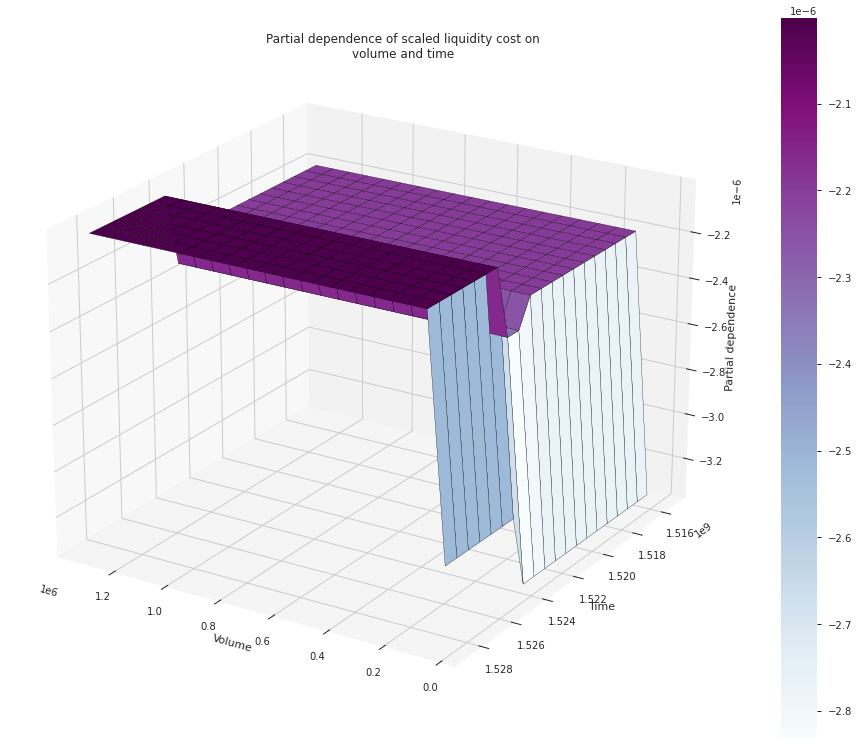

In [92]:
fig = plt.figure(figsize=(15,10))

features = ('Volume', 'Time')
pdp, axes = partial_dependence(etr_model, X, features=features,
                               grid_resolution=20)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of scaled liquidity cost on\n'
             'volume and time')
plt.subplots_adjust(top=0.9)

plt.show()

In [93]:
import shap

# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(etr_model)
shap_values = explainer.shap_values(X)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


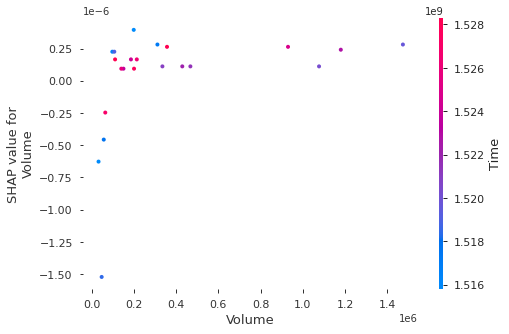

In [106]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Volume", shap_values, X)

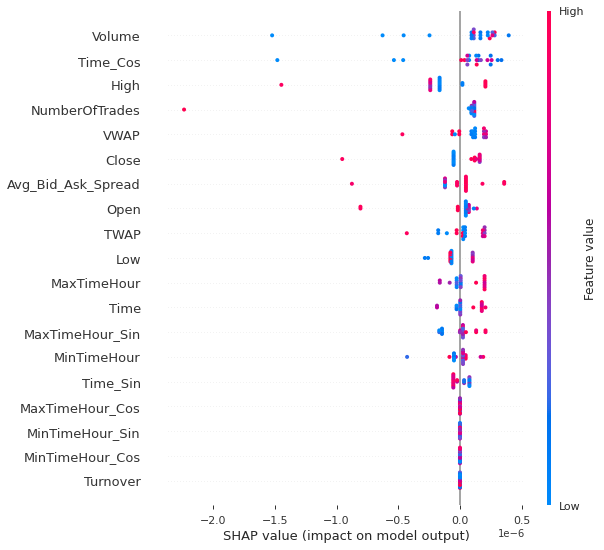

In [115]:
shap.summary_plot(shap_values, X)

In [96]:
X

,Time,Open,High,Low,Close,VWAP,TWAP,NumberOfTrades,Volume,Turnover,MinTimeHour,MaxTimeHour,Avg_Bid_Ask_Spread,Time_Sin,Time_Cos,MinTimeHour_Sin,MinTimeHour_Cos,MaxTimeHour_Sin,MaxTimeHour_Cos
0,1.515139e+09,53.863636,53.959091,53.509091,53.545455,53.753585,53.743282,2114,1.995475e+05,1.297645e+09,1.515139,1.515139,-0.064738,8.660254e-01,-0.500000,0.000110,1.0,0.000110,1.0
48,1.515755e+09,53.363636,53.457364,53.336364,53.381818,53.391579,53.389514,566,3.295418e+04,2.128883e+08,1.515755,1.515755,0.009949,2.588190e-01,-0.965926,0.000110,1.0,0.000110,1.0
96,1.516370e+09,54.254545,54.254545,54.100273,54.172727,54.172048,54.171453,1389,9.815336e+04,6.433703e+08,1.516370,1.516370,0.010353,-5.000000e-01,-0.866025,0.000110,1.0,0.000110,1.0
144,1.517213e+09,51.636364,51.763636,51.145455,51.154545,51.350585,51.336173,3976,3.117075e+05,1.936226e+09,1.517213,1.517213,-0.010975,8.660254e-01,-0.500000,0.000110,1.0,0.000110,1.0
192,1.517825e+09,50.218182,50.318182,50.190909,50.254545,50.242114,50.241466,800,5.761845e+04,3.502751e+08,1.517825,1.517825,0.011521,5.000000e-01,-0.866025,0.000110,1.0,0.000110,1.0
240,1.518437e+09,52.736364,52.800000,52.672727,52.736364,52.741323,52.734738,658,4.771709e+04,3.044781e+08,1.518437,1.518437,0.001981,1.615281e-11,-1.000000,0.000110,1.0,0.000110,1.0
288,1.519052e+09,53.754545,53.809091,53.645455,53.800000,53.725462,53.724381,1615,1.075495e+05,6.991414e+08,1.519052,1.519052,0.009997,-7.071068e-01,-0.707107,0.000110,1.0,0.000110,1.0
336,1.519661e+09,50.072727,50.618182,49.927273,50.618182,50.067264,50.025751,2410,1.473813e+06,8.921161e+09,1.519661,1.519661,-0.143645,-8.660254e-01,-0.500000,0.000111,1.0,0.000111,1.0
384,1.520269e+09,47.990909,47.990909,47.990909,47.990909,47.990909,47.990909,3,1.076829e+06,6.253037e+09,1.520269,1.520269,1.941967,-9.659258e-01,-0.258819,0.000111,1.0,0.000111,1.0
432,1.520935e+09,44.231818,44.645455,44.118182,44.295455,44.444055,44.453105,5488,3.352829e+05,1.803428e+09,1.520935,1.520935,0.009027,5.000000e-01,-0.866025,0.000111,1.0,0.000111,1.0
